## Compute tau values for each transcript to see how population-specific they are 

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [2]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [3]:
def compute_tau(df):
    """
    Compute tissue-specificity index for an abundance matrix output
    from `get_tpm_table`.
    """
    # number of samples 
    n = len(df.columns)
    print(f'Found {n} samples')
    
    # log-transform data and add 1 pseudocount to data
    df = np.log2(df+1)
    # df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # get max of TPM for transcript across samples
    temp = df.max(axis=1)
    temp_ind = temp.index.tolist()

    df = df.transpose()
    df_ind = df.columns.tolist()
    assert df_ind==temp_ind

    # compute x-hat (TPM / max TPM across tissues)
    x_hat = df/temp
    
    # compute (1-x-hat) 
    x_hat = 1-x_hat

    # compute sum across tissues
    x_hat = x_hat.transpose()
    x_hat['sum'] = x_hat.sum(axis=1)
    
    # compute tau for each transcript
    x_hat['tau'] = x_hat['sum']/n
    tau_df = x_hat[['tau']]
    
    return tau_df

In [4]:
f = expand(proc_cfg(config['lr']['kallisto']['quant']['merge_matrix_tpm_tsv'],od))[0]

meta = load_meta()
meta = meta.loc[meta.merged_run_mode==True]
sample_d = dict([(entry.cell_line_id, entry['sample']) \
                 for ind, entry in meta.iterrows()])


df = pd.read_csv(f, sep='\t')
df.head()
df.columns = [d if d == 'transcript_id' else d.split('_')[0] for d in df.columns]
df.rename({'transcript_id':'tid'}, axis=1, inplace=True)
df.rename(sample_d, axis=1, inplace=True)
df.set_index('tid', inplace=True)

In [5]:
# get the mean expression value across samples from the same populations
df = df.transpose()
df.reset_index(inplace=True)
df.rename({'index':'sample'}, axis=1, inplace=True)
df = df.merge(meta[['sample', 'population']], 
              how='left', on='sample')
df = df.groupby('population').mean().reset_index()
df.set_index('population', inplace=True)
df.index.name = ''
df = df.transpose()
df.head()

,AJI,CEU,HAC,ITU,LWK,MPC,PEL,YRI
ENST00000413811.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
transcript_6675,0.364595,0.206081,0.348632,0.541199,0.459595,0.675766,0.694056,0.372693
transcript_6676,0.850381,0.625232,0.564991,0.716487,0.513411,0.570094,0.515104,0.684088
transcript_6684,0.688726,0.431695,0.393302,0.655868,0.597672,0.650575,0.622874,0.510741
transcript_6687,0.039410,0.049406,0.033497,0.017817,0.000000,0.087052,0.068709,0.000000


In [6]:
tau_df = compute_tau(df)

Found 8 samples


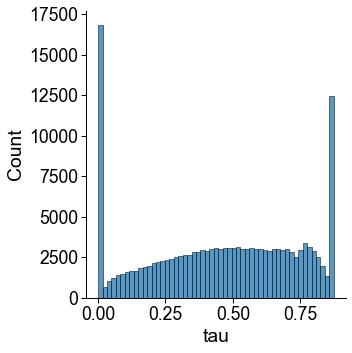

In [7]:
init_plot_settings(aspect='square')
sns.displot(tau_df, x='tau', kind='hist')

In [8]:
high_tau = tau_df.loc[tau_df.tau>=0.75]

In [9]:
high_tau.head()
len(high_tau.index)
high_tau.reset_index(inplace=True)
high_tau.rename({'index':'tid'}, axis=1, inplace=True)

In [10]:
## what structural categories are high-tau transcripts?
mt_df = pd.read_csv('../data/05_mastertable/master_table.tsv', sep='\t')
mt_df = mt_df.loc[mt_df['filter']=='pass']
mt_df['pop_spec_t'] = (mt_df.population_sharing==1)&\
                      (mt_df.sample_sharing>1)

In [11]:
len(mt_df.isoform.unique())

162816

In [12]:
# temp = mt_df.loc[mt_df.isoform.isin(high_tau.index.tolist())]
high_tau = high_tau.merge(mt_df[['isoform', 'structural_category']], 
                how='left',
                left_on='tid',
                right_on='isoform')
assert len(high_tau.loc[high_tau.isoform.isnull()].index) == \
       len(high_tau.loc[(high_tau.tid.str.startswith('ENST'))&\
                        (high_tau.isoform.isnull())].index)

In [13]:
# now we can assume everything that's null is FSM
high_tau.loc[high_tau.structural_category.isnull(), 'structural_category'] = 'FSM'

In [14]:
c_dict, order = get_novelty_colors()

In [15]:
temp = high_tau[['structural_category', 'tid']].groupby('structural_category').count().rename({'tid':'n_t'}, axis=1).reset_index()

In [16]:
order

['FSM', 'ISM', 'NIC', 'NNC', 'Intergenic', 'Genic', 'Fusion', 'Antisense']

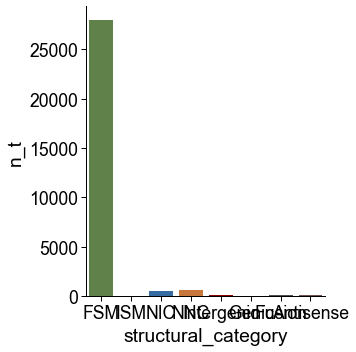

In [18]:
ax = sns.catplot(temp, y='n_t',x='structural_category',
            kind='bar', palette=c_dict, order=order, 
            saturation=1)

In [ ]:
## BOX plots of expression of high tau transcripts across populations

In [ ]:
f = expand(proc_cfg(config['lr']['kallisto']['quant']['merge_matrix_tpm_tsv'],od))[0]

meta = load_meta()
meta = meta.loc[meta.merged_run_mode==True]
sample_d = dict([(entry.cell_line_id, entry['sample']) \
                 for ind, entry in meta.iterrows()])


df = pd.read_csv(f, sep='\t')
df.head()
df.columns = [d if d == 'transcript_id' else d.split('_')[0] for d in df.columns]
df.rename({'transcript_id':'tid'}, axis=1, inplace=True)
df.rename(sample_d, axis=1, inplace=True)
df.set_index('tid', inplace=True)

In [29]:
log_df = np.log2(df+1)
log_df = log_df.transpose()
log_df.reset_index(inplace=True)
log_df.rename({'index':'sample'}, axis=1, inplace=True)
log_df = log_df.merge(meta[['sample', 'population']], 
              how='left', on='sample')
# log_df.set_index('population', inplace=True)
log_df.index.name = ''
log_df.head()

,sample,ENST00000413811.3,transcript_6675,transcript_6676,transcript_6684,transcript_6687,transcript_7913,transcript_11363,transcript_11364,transcript_11365,...,transcript_323,transcript_324,transcript_325,transcript_326,transcript_327,transcript_190970,transcript_190971,transcript_328,transcript_329,population
,,,,,,,,,,,,,,,,,,,,,
0,YRI5,0.0,0.478421,0.967951,0.258952,0.000000,0.00000,0.574507,0.450883,0.166448,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,YRI
1,YRI6,0.0,0.000000,0.524843,1.166844,0.000000,0.00000,0.538834,0.294428,0.154713,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,YRI
2,YRI7,0.0,0.634343,1.127092,0.705864,0.000000,0.00000,0.529828,0.289101,0.314512,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,YRI
3,HAC1,0.0,0.172587,0.813163,0.000000,0.078001,0.06995,0.548518,0.072309,0.324798,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035399,HAC
4,HAC2,0.0,0.471429,1.351063,0.634301,0.000000,0.00000,0.773998,0.131049,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.122673,HAC


In [32]:
log_df = log_df.melt(id_vars=['sample', 'population'],
            var_name='tid', value_name='log2tpm')

In [33]:
c_dict, order = get_population_colors()

In [ ]:
tid = ''